# ElasticAST evaluated on Epic-Sound
All the evaluation logs can be observed below.

When doing it your self, please change the directory accordingly.

NOTE: Epic-Sound is a various-length dataset, and the experiments are used to measure the performance for **native length**.

Here we use the results from seed A, which also shows at https://sites.google.com/view/elasticast-interpseech24

## Create and load the model

In [ ]:
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from tqdm import tqdm


from models import ElasticAST
import numpy as np
import dataloader
from utilities import *


model = ElasticAST(
    sample_size = (128,3072),
    patch_size = 16,
    num_classes = 44,
    dim = 768,
    depth = 12,
    heads = 12,
    dropout = 0,
    emb_dropout = 0,
    token_dropout_prob = 0,  # token dropout of 10% (keep 90% of tokens)
    channels=1,
)


model_load = "/home/jfeng/FJ/ElasticAST/pretrain_weights/ElasticAST_EpicSound.pth"


out_dict = {}
state_dict = torch.load(model_load,map_location=torch.device('cpu'))
for k, v in state_dict.items(): # Adjust the name of dict
    out_dict[k[7:]] = v
model.load_state_dict(out_dict, strict=True)

## Prepare for the datasets and evaluation pipelines.

In [2]:
import copy
from fvcore.common.config import CfgNode
import yaml
from epic_data import loader

# Load the YAML file
yaml_file = "/home/jfeng/FJ/ElasticAST/egs/epic-sound/data/epic_config.yaml"
with open(yaml_file, 'r') as f:
    cfg_dict = yaml.safe_load(f)


length = np.arange(128*2, 128*24+1,128)
# append two special cases
length = np.append(length, 400)
length = np.append(length, 1600)
length = np.sort(length)

quality_acc = []

ori_size = get_shape(16,16,16,input_tdim=int(1024))


for l in length:
    # Convert dictionary to CfgNode
    cfg = CfgNode(cfg_dict)
    cfg.TRAIN.DATASET = "Epicsounds_elastic"
    cfg.T_MASK = 0
    cfg.F_MASK = 0
    cfg.T_WARP = 5
    cfg.AUDIO_DATA.NUM_FRAMES = int(l)
    cfg.MIN_AUDIO_LENGTH = 192
    cfg.DATA_LOADER.NUM_WORKERS=16
    cfg.RANDOM=False


    val_loader = loader.construct_loader_elastic(cfg, "val")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        A_predictions = []
        A_targets = []
        A_loss = []
        with tqdm(val_loader) as vepoch:
            for data_items, labels in vepoch:
                data_items, labels = data_items, labels
                for i in range(len(data_items)):
                    data_items[i] = data_items[i].to(device)
                outputs = model(data_items,group_samples=True,group_max_seq_len=2048)
                outputs = torch.sigmoid(outputs)
                predictions = outputs.to('cpu').detach()

                A_predictions.append(predictions)
                A_targets.append(labels)

                labels = labels.to(device)


        outputs = torch.cat(A_predictions)
        labels = torch.cat(A_targets)
        stats = calculate_stats(outputs, labels)

    mAP = np.mean([stat['AP'] for stat in stats])
    acc = stats[0]['acc']
    print(f"Quality ratio: {l}, mAP: {mAP}, acc: {acc}")
    quality_acc.append(acc)

print(quality_acc)


100%|██████████| 670/670 [00:59<00:00, 11.35it/s]


Quality ratio: 256, mAP: 0.19271589585240695, acc: 0.48164281269446174


100%|██████████| 670/670 [01:00<00:00, 11.03it/s]


Quality ratio: 384, mAP: 0.2009552937633239, acc: 0.5001866832607342


100%|██████████| 670/670 [01:01<00:00, 10.91it/s]


Quality ratio: 400, mAP: 0.20218912856710958, acc: 0.5001866832607342


100%|██████████| 670/670 [01:01<00:00, 10.92it/s]


Quality ratio: 512, mAP: 0.20602310641224966, acc: 0.5072806471686372


100%|██████████| 670/670 [01:02<00:00, 10.77it/s]


Quality ratio: 640, mAP: 0.20882594872418683, acc: 0.5108898568761667


100%|██████████| 670/670 [01:01<00:00, 10.90it/s]


Quality ratio: 768, mAP: 0.20991854119968262, acc: 0.5133789670192906


100%|██████████| 670/670 [01:01<00:00, 10.84it/s]


Quality ratio: 896, mAP: 0.21152969737433047, acc: 0.5157436216552582


100%|██████████| 670/670 [01:01<00:00, 10.85it/s]


Quality ratio: 1024, mAP: 0.21164159736135196, acc: 0.5176104542626011


100%|██████████| 670/670 [01:02<00:00, 10.78it/s]


Quality ratio: 1152, mAP: 0.212356868050159, acc: 0.5176104542626011


100%|██████████| 670/670 [01:01<00:00, 10.81it/s]


Quality ratio: 1280, mAP: 0.21292023435589275, acc: 0.5184816428126945


100%|██████████| 670/670 [01:02<00:00, 10.79it/s]


Quality ratio: 1408, mAP: 0.21378971826974683, acc: 0.5189794648413192


100%|██████████| 670/670 [01:02<00:00, 10.81it/s]


Quality ratio: 1536, mAP: 0.21490829949493753, acc: 0.5196017423771002


100%|██████████| 670/670 [01:02<00:00, 10.70it/s]


Quality ratio: 1600, mAP: 0.2150330935764929, acc: 0.5203484754200374


100%|██████████| 670/670 [01:02<00:00, 10.75it/s]


Quality ratio: 1664, mAP: 0.21596691386643407, acc: 0.5212196639701306


100%|██████████| 670/670 [01:02<00:00, 10.71it/s]


Quality ratio: 1792, mAP: 0.21615935645556694, acc: 0.5222153080273803


100%|██████████| 670/670 [01:02<00:00, 10.78it/s]


Quality ratio: 1920, mAP: 0.2162930627500087, acc: 0.5218419415059117


100%|██████████| 670/670 [01:03<00:00, 10.62it/s]


Quality ratio: 2048, mAP: 0.21746853747078215, acc: 0.5218419415059117


100%|██████████| 670/670 [01:02<00:00, 10.65it/s]


Quality ratio: 2176, mAP: 0.21818527320167852, acc: 0.5224642190416926


100%|██████████| 670/670 [01:02<00:00, 10.67it/s]


Quality ratio: 2304, mAP: 0.2188653047483908, acc: 0.523335407591786


100%|██████████| 670/670 [01:03<00:00, 10.63it/s]


Quality ratio: 2432, mAP: 0.21937670394678915, acc: 0.5240821406347231


100%|██████████| 670/670 [01:03<00:00, 10.62it/s]


Quality ratio: 2560, mAP: 0.2191332145819878, acc: 0.5229620410703174


100%|██████████| 670/670 [01:02<00:00, 10.75it/s]


Quality ratio: 2688, mAP: 0.2197067846743759, acc: 0.5228375855631612


100%|██████████| 670/670 [01:02<00:00, 10.70it/s]


Quality ratio: 2816, mAP: 0.2185663668365763, acc: 0.5230864965774735


100%|██████████| 670/670 [01:02<00:00, 10.68it/s]


Quality ratio: 2944, mAP: 0.2203509604447045, acc: 0.5225886745488488


100%|██████████| 670/670 [01:02<00:00, 10.64it/s]


Quality ratio: 3072, mAP: 0.22008337532639055, acc: 0.5224642190416926
[0.48164281269446174, 0.5001866832607342, 0.5001866832607342, 0.5072806471686372, 0.5108898568761667, 0.5133789670192906, 0.5157436216552582, 0.5176104542626011, 0.5176104542626011, 0.5184816428126945, 0.5189794648413192, 0.5196017423771002, 0.5203484754200374, 0.5212196639701306, 0.5222153080273803, 0.5218419415059117, 0.5218419415059117, 0.5224642190416926, 0.523335407591786, 0.5240821406347231, 0.5229620410703174, 0.5228375855631612, 0.5230864965774735, 0.5225886745488488, 0.5224642190416926]


In [3]:
# What we obtained above is:
len_cut = [0.48164281269446174, 0.5001866832607342, 0.5001866832607342, 0.5072806471686372, 0.5108898568761667, 0.5133789670192906, 0.5157436216552582, 0.5176104542626011, 0.5176104542626011, 0.5184816428126945, 0.5189794648413192, 0.5196017423771002, 0.5203484754200374, 0.5212196639701306, 0.5222153080273803, 0.5218419415059117, 0.5218419415059117, 0.5224642190416926, 0.523335407591786, 0.5240821406347231, 0.5229620410703174, 0.5228375855631612, 0.5230864965774735, 0.5225886745488488, 0.5224642190416926]

# Belows are the baseline results from 128x256 to 128x3072
baseline_1024 = [0.4357187306, 0.4713130056, 0.4749222153, 0.4930927194, 0.4973242066, 0.5015556938, 0.5000622278, 0.5009334163, 0.4969508401, 0.4963285625, 0.4953329185, 0.4925948973, 0.4917237088, 0.4912258867, 0.4859987554, 0.4827629123, 0.4802738021, 0.4757934039, 0.4723086497, 0.468948351, 0.4644679527, 0.4609831985, 0.4574984443, 0.4541381456, 0.4510267579]
baseline_400  = [0.4851275669, 0.5076540137, 0.5100186683, 0.5082762912, 0.5016801493, 0.4913503423, 0.4835096453, 0.4747977598, 0.4675793404, 0.4624766646, 0.4536403236, 0.4453018046, 0.4409458619, 0.4387056627, 0.4331051649, 0.4277535781, 0.4211574362, 0.4161792159, 0.4109520846, 0.4042314872, 0.3988799004, 0.3950217797, 0.3904169259, 0.3869321717, 0.382327318]
baseline_1600 = [0.4189172371, 0.453018046, 0.4567517113, 0.4810205352, 0.4906036092, 0.4918481643, 0.496204107, 0.496453018, 0.4984443062, 0.4980709396, 0.4969508401, 0.4955818295, 0.4950840075, 0.4935905414, 0.4943372744, 0.4924704418, 0.4898568762, 0.4879900436, 0.486621033, 0.4840074673, 0.4808960797, 0.477784692, 0.4759178594, 0.4752955818, 0.4720597386]

# Visualization

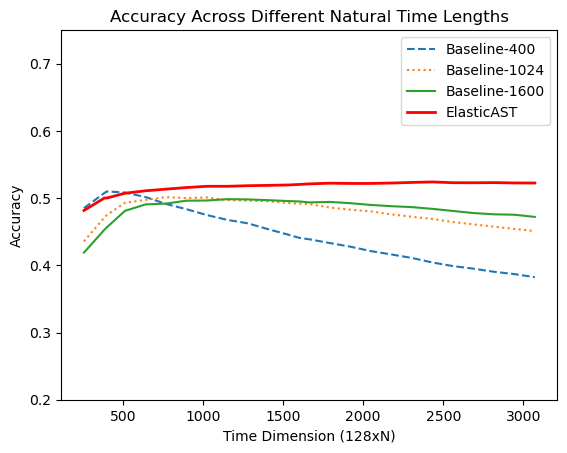

In [5]:
# draw the plot
import matplotlib.pyplot as plt
plt.plot(length, baseline_400, label="Baseline-400",linestyle='--')
plt.plot(length, baseline_1024, label="Baseline-1024",linestyle=':')
plt.plot(length, baseline_1600, label="Baseline-1600",linestyle='-')
plt.plot(length, len_cut, label="ElasticAST",color='r',linewidth=2)

plt.legend()
plt.xlabel("Time Dimension (128xN)")
plt.ylabel("Accuracy")
plt.title("Accuracy Across Different Natural Time Lengths")

plt.ylim(0.2, 0.75)

plt.show()